### Three Tasks with concatenation
This example notebook illustrates the main functionalities of `torchmtl`:
* Modularized composition of multi-task architectures
* Merging of results from different branches
* Jointly optimizing all tasks

In the following cells, we will set up a network which
1. Feeds the input through two different "embedding" layers
2. Concatenates the output of both layers from 1.
3. Trains *task 1* on this concatenation
4. "Forwards" the concatenation of the embeddings to a middle layer
5. Trains *task 2* on this middle layer
6. "Forwards" the output of the middle layer to a second middle layer
7. Trains *task 3* on this last middle layer

The used layers in each node of the meta computation-graph are held very simple but could contain any `pytorch` compatible modules. Furthermore, we don't showcase a real train/val/test split but simply overfit on a random data set to illustrate the usage of the library.

First, we will set the logging level to DEBUG which allows to follow the flow of data in the meta computation-graph.

In [1]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

Then import necessary classes and modules.

In [2]:
# PyTorch imports
import torch
from torch import nn
import torch.optim as optim
from torch.nn import (Linear, Sequential, MSELoss)

# Import networkx for visualization
import networkx as nx

# torchMTL imports
from torchmtl import MTLModel
from torchmtl.wrapping_layers import Concat

# Some imports for the visualization of loss curves
import matplotlib.pyplot as plt
from collections import defaultdict

Now, we define the multi-task model ...

In [3]:
tasks = [
        {
            'name': "InputTask2",
            'layers': Sequential(*[Linear(16, 32), Linear(32, 8)]),
            # No anchor_layer means this layer receives input directly
        },    
        {
            'name': "InputTask1",
            'layers': Sequential(*[Linear(16, 32), Linear(32, 8)]),
            # No anchor_layer means this layer receives input directly
        },
        {
            'name': "CombTask",
            'layers': Concat(dim=1),
            # We combine outputs from other layers by providing their names in a list
            'anchor_layer': ['InputTask1', 'InputTask2'] 
        },
        {
            'name': "Task1",
            'layers': Sequential(*[Linear(16, 32), Linear(32, 1)]),
            'loss': MSELoss(), # In this example we will only use the MSELoss for simplicity
            'loss_weight': 1.0,
            'anchor_layer': 'CombTask'            
        },
        {
            'name': "MiddleTask1",
            'layers': Sequential(*[Linear(16, 32), Linear(32, 8)]),
            'anchor_layer': 'CombTask'
        },    
        {
            'name': "Task2",
            'layers': Sequential(*[Linear(8, 32), Linear(32, 1)]),
            'loss': MSELoss(),
            'loss_weight': 1.0,
            'anchor_layer': 'MiddleTask1'
        },
        {
            'name': "MiddleTask2",
            'layers': Sequential(*[Linear(8, 32), Linear(32, 4)]),
            'anchor_layer': 'MiddleTask1'
        },
        {
            'name': "Task3",
            'layers': Sequential(*[Linear(4, 32), Linear(32, 1)]),
            'loss': MSELoss(),
            'loss_weight': 'auto', # Here we make use of being able to learn the weighting of the loss
            'loss_init_val': 0.5,
            'anchor_layer': 'MiddleTask2'
        }
    ]

... define from which layers we would like to receive predictions (output of their 'layers' key), loss function, and scaling factor. 

In [4]:
output_tasks=['Task1', 'Task2', 'Task3']

... and build and visualize it

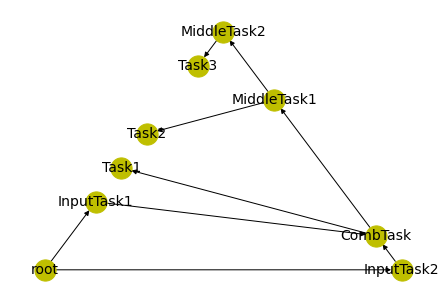

In [5]:
model = MTLModel(tasks, output_tasks=output_tasks)

pos = nx.planar_layout(model.g)
nx.draw(model.g, pos, font_size=14, node_color="y", node_size=450, with_labels=True)

In [6]:
# Define an optimizer
optimizer = optim.AdamW(model.parameters(), lr=0.01)

# Generate a small data set of random features
torch.manual_seed(42)
sample_size = 16
X = torch.rand((sample_size, 16))

# We will fit three different regressions. Here we define
# the ground truth.
truths_1 = torch.ones(sample_size, 1) * 10.
truths_2 = torch.ones(sample_size, 1) * 20.
truths_3 = torch.ones(sample_size, 1) * 30.
y = [truths_1, truths_2, truths_3]

num_it = 500
losses = defaultdict(list)
for i in range(num_it):
    optimizer.zero_grad()

    y_hat, l_funcs, l_weights = model(X)
    loss = 0
    for i in range(len(y)):
        # Compute the loss
        ith_loss = l_funcs[i](y_hat[i], y[i])
        
        # Squeeze in a dimension to fit the scaling value (only necessary for the 'auto' loss)
        ith_loss = ith_loss.unsqueeze(0)
        loss += l_weights[i] * ith_loss
        
        # Add current loss to loss dict for visualization
        losses[i].append((l_weights[i] * ith_loss).item())
    
    # Add overall loss to loss dict for visualization
    losses[-1].append(loss.item())
    
    loss.backward()
    optimizer.step()

Feeding output from ['root'] into InputTask2
Feeding output from ['root'] into InputTask1
Feeding output from ['InputTask1', 'InputTask2'] into CombTask
Feeding output from ['CombTask'] into Task1
Feeding output from ['CombTask'] into MiddleTask1
Feeding output from ['MiddleTask1'] into Task2
Feeding output from ['MiddleTask1'] into MiddleTask2
Feeding output from ['MiddleTask2'] into Task3
Feeding output from ['root'] into InputTask2
Feeding output from ['root'] into InputTask1
Feeding output from ['InputTask1', 'InputTask2'] into CombTask
Feeding output from ['CombTask'] into Task1
Feeding output from ['CombTask'] into MiddleTask1
Feeding output from ['MiddleTask1'] into Task2
Feeding output from ['MiddleTask1'] into MiddleTask2
Feeding output from ['MiddleTask2'] into Task3
Feeding output from ['root'] into InputTask2
Feeding output from ['root'] into InputTask1
Feeding output from ['InputTask1', 'InputTask2'] into CombTask
Feeding output from ['CombTask'] into Task1
Feeding output 

Feeding output from ['root'] into InputTask2
Feeding output from ['root'] into InputTask1
Feeding output from ['InputTask1', 'InputTask2'] into CombTask
Feeding output from ['CombTask'] into Task1
Feeding output from ['CombTask'] into MiddleTask1
Feeding output from ['MiddleTask1'] into Task2
Feeding output from ['MiddleTask1'] into MiddleTask2
Feeding output from ['MiddleTask2'] into Task3
Feeding output from ['root'] into InputTask2
Feeding output from ['root'] into InputTask1
Feeding output from ['InputTask1', 'InputTask2'] into CombTask
Feeding output from ['CombTask'] into Task1
Feeding output from ['CombTask'] into MiddleTask1
Feeding output from ['MiddleTask1'] into Task2
Feeding output from ['MiddleTask1'] into MiddleTask2
Feeding output from ['MiddleTask2'] into Task3
Feeding output from ['root'] into InputTask2
Feeding output from ['root'] into InputTask1
Feeding output from ['InputTask1', 'InputTask2'] into CombTask
Feeding output from ['CombTask'] into Task1
Feeding output 

Feeding output from ['root'] into InputTask2
Feeding output from ['root'] into InputTask1
Feeding output from ['InputTask1', 'InputTask2'] into CombTask
Feeding output from ['CombTask'] into Task1
Feeding output from ['CombTask'] into MiddleTask1
Feeding output from ['MiddleTask1'] into Task2
Feeding output from ['MiddleTask1'] into MiddleTask2
Feeding output from ['MiddleTask2'] into Task3
Feeding output from ['root'] into InputTask2
Feeding output from ['root'] into InputTask1
Feeding output from ['InputTask1', 'InputTask2'] into CombTask
Feeding output from ['CombTask'] into Task1
Feeding output from ['CombTask'] into MiddleTask1
Feeding output from ['MiddleTask1'] into Task2
Feeding output from ['MiddleTask1'] into MiddleTask2
Feeding output from ['MiddleTask2'] into Task3
Feeding output from ['root'] into InputTask2
Feeding output from ['root'] into InputTask1
Feeding output from ['InputTask1', 'InputTask2'] into CombTask
Feeding output from ['CombTask'] into Task1
Feeding output 

Feeding output from ['root'] into InputTask2
Feeding output from ['root'] into InputTask1
Feeding output from ['InputTask1', 'InputTask2'] into CombTask
Feeding output from ['CombTask'] into Task1
Feeding output from ['CombTask'] into MiddleTask1
Feeding output from ['MiddleTask1'] into Task2
Feeding output from ['MiddleTask1'] into MiddleTask2
Feeding output from ['MiddleTask2'] into Task3
Feeding output from ['root'] into InputTask2
Feeding output from ['root'] into InputTask1
Feeding output from ['InputTask1', 'InputTask2'] into CombTask
Feeding output from ['CombTask'] into Task1
Feeding output from ['CombTask'] into MiddleTask1
Feeding output from ['MiddleTask1'] into Task2
Feeding output from ['MiddleTask1'] into MiddleTask2
Feeding output from ['MiddleTask2'] into Task3
Feeding output from ['root'] into InputTask2
Feeding output from ['root'] into InputTask1
Feeding output from ['InputTask1', 'InputTask2'] into CombTask
Feeding output from ['CombTask'] into Task1
Feeding output 

Feeding output from ['root'] into InputTask2
Feeding output from ['root'] into InputTask1
Feeding output from ['InputTask1', 'InputTask2'] into CombTask
Feeding output from ['CombTask'] into Task1
Feeding output from ['CombTask'] into MiddleTask1
Feeding output from ['MiddleTask1'] into Task2
Feeding output from ['MiddleTask1'] into MiddleTask2
Feeding output from ['MiddleTask2'] into Task3
Feeding output from ['root'] into InputTask2
Feeding output from ['root'] into InputTask1
Feeding output from ['InputTask1', 'InputTask2'] into CombTask
Feeding output from ['CombTask'] into Task1
Feeding output from ['CombTask'] into MiddleTask1
Feeding output from ['MiddleTask1'] into Task2
Feeding output from ['MiddleTask1'] into MiddleTask2
Feeding output from ['MiddleTask2'] into Task3
Feeding output from ['root'] into InputTask2
Feeding output from ['root'] into InputTask1
Feeding output from ['InputTask1', 'InputTask2'] into CombTask
Feeding output from ['CombTask'] into Task1
Feeding output 

Feeding output from ['MiddleTask2'] into Task3
Feeding output from ['root'] into InputTask2
Feeding output from ['root'] into InputTask1
Feeding output from ['InputTask1', 'InputTask2'] into CombTask
Feeding output from ['CombTask'] into Task1
Feeding output from ['CombTask'] into MiddleTask1
Feeding output from ['MiddleTask1'] into Task2
Feeding output from ['MiddleTask1'] into MiddleTask2
Feeding output from ['MiddleTask2'] into Task3
Feeding output from ['root'] into InputTask2
Feeding output from ['root'] into InputTask1
Feeding output from ['InputTask1', 'InputTask2'] into CombTask
Feeding output from ['CombTask'] into Task1
Feeding output from ['CombTask'] into MiddleTask1
Feeding output from ['MiddleTask1'] into Task2
Feeding output from ['MiddleTask1'] into MiddleTask2
Feeding output from ['MiddleTask2'] into Task3
Feeding output from ['root'] into InputTask2
Feeding output from ['root'] into InputTask1
Feeding output from ['InputTask1', 'InputTask2'] into CombTask
Feeding outp

Feeding output from ['root'] into InputTask2
Feeding output from ['root'] into InputTask1
Feeding output from ['InputTask1', 'InputTask2'] into CombTask
Feeding output from ['CombTask'] into Task1
Feeding output from ['CombTask'] into MiddleTask1
Feeding output from ['MiddleTask1'] into Task2
Feeding output from ['MiddleTask1'] into MiddleTask2
Feeding output from ['MiddleTask2'] into Task3
Feeding output from ['root'] into InputTask2
Feeding output from ['root'] into InputTask1
Feeding output from ['InputTask1', 'InputTask2'] into CombTask
Feeding output from ['CombTask'] into Task1
Feeding output from ['CombTask'] into MiddleTask1
Feeding output from ['MiddleTask1'] into Task2
Feeding output from ['MiddleTask1'] into MiddleTask2
Feeding output from ['MiddleTask2'] into Task3
Feeding output from ['root'] into InputTask2
Feeding output from ['root'] into InputTask1
Feeding output from ['InputTask1', 'InputTask2'] into CombTask
Feeding output from ['CombTask'] into Task1
Feeding output 

Feeding output from ['root'] into InputTask2
Feeding output from ['root'] into InputTask1
Feeding output from ['InputTask1', 'InputTask2'] into CombTask
Feeding output from ['CombTask'] into Task1
Feeding output from ['CombTask'] into MiddleTask1
Feeding output from ['MiddleTask1'] into Task2
Feeding output from ['MiddleTask1'] into MiddleTask2
Feeding output from ['MiddleTask2'] into Task3
Feeding output from ['root'] into InputTask2
Feeding output from ['root'] into InputTask1
Feeding output from ['InputTask1', 'InputTask2'] into CombTask
Feeding output from ['CombTask'] into Task1
Feeding output from ['CombTask'] into MiddleTask1
Feeding output from ['MiddleTask1'] into Task2
Feeding output from ['MiddleTask1'] into MiddleTask2
Feeding output from ['MiddleTask2'] into Task3
Feeding output from ['root'] into InputTask2
Feeding output from ['root'] into InputTask1
Feeding output from ['InputTask1', 'InputTask2'] into CombTask
Feeding output from ['CombTask'] into Task1
Feeding output 

Feeding output from ['MiddleTask1'] into MiddleTask2
Feeding output from ['MiddleTask2'] into Task3
Feeding output from ['root'] into InputTask2
Feeding output from ['root'] into InputTask1
Feeding output from ['InputTask1', 'InputTask2'] into CombTask
Feeding output from ['CombTask'] into Task1
Feeding output from ['CombTask'] into MiddleTask1
Feeding output from ['MiddleTask1'] into Task2
Feeding output from ['MiddleTask1'] into MiddleTask2
Feeding output from ['MiddleTask2'] into Task3
Feeding output from ['root'] into InputTask2
Feeding output from ['root'] into InputTask1
Feeding output from ['InputTask1', 'InputTask2'] into CombTask
Feeding output from ['CombTask'] into Task1
Feeding output from ['CombTask'] into MiddleTask1
Feeding output from ['MiddleTask1'] into Task2
Feeding output from ['MiddleTask1'] into MiddleTask2
Feeding output from ['MiddleTask2'] into Task3
Feeding output from ['root'] into InputTask2
Feeding output from ['root'] into InputTask1
Feeding output from ['

Feeding output from ['root'] into InputTask2
Feeding output from ['root'] into InputTask1
Feeding output from ['InputTask1', 'InputTask2'] into CombTask
Feeding output from ['CombTask'] into Task1
Feeding output from ['CombTask'] into MiddleTask1
Feeding output from ['MiddleTask1'] into Task2
Feeding output from ['MiddleTask1'] into MiddleTask2
Feeding output from ['MiddleTask2'] into Task3
Feeding output from ['root'] into InputTask2
Feeding output from ['root'] into InputTask1
Feeding output from ['InputTask1', 'InputTask2'] into CombTask
Feeding output from ['CombTask'] into Task1
Feeding output from ['CombTask'] into MiddleTask1
Feeding output from ['MiddleTask1'] into Task2
Feeding output from ['MiddleTask1'] into MiddleTask2
Feeding output from ['MiddleTask2'] into Task3
Feeding output from ['root'] into InputTask2
Feeding output from ['root'] into InputTask1
Feeding output from ['InputTask1', 'InputTask2'] into CombTask
Feeding output from ['CombTask'] into Task1
Feeding output 

Feeding output from ['CombTask'] into MiddleTask1
Feeding output from ['MiddleTask1'] into Task2
Feeding output from ['MiddleTask1'] into MiddleTask2
Feeding output from ['MiddleTask2'] into Task3
Feeding output from ['root'] into InputTask2
Feeding output from ['root'] into InputTask1
Feeding output from ['InputTask1', 'InputTask2'] into CombTask
Feeding output from ['CombTask'] into Task1
Feeding output from ['CombTask'] into MiddleTask1
Feeding output from ['MiddleTask1'] into Task2
Feeding output from ['MiddleTask1'] into MiddleTask2
Feeding output from ['MiddleTask2'] into Task3
Feeding output from ['root'] into InputTask2
Feeding output from ['root'] into InputTask1
Feeding output from ['InputTask1', 'InputTask2'] into CombTask
Feeding output from ['CombTask'] into Task1
Feeding output from ['CombTask'] into MiddleTask1
Feeding output from ['MiddleTask1'] into Task2
Feeding output from ['MiddleTask1'] into MiddleTask2
Feeding output from ['MiddleTask2'] into Task3
Feeding output 

Feeding output from ['root'] into InputTask2
Feeding output from ['root'] into InputTask1
Feeding output from ['InputTask1', 'InputTask2'] into CombTask
Feeding output from ['CombTask'] into Task1
Feeding output from ['CombTask'] into MiddleTask1
Feeding output from ['MiddleTask1'] into Task2
Feeding output from ['MiddleTask1'] into MiddleTask2
Feeding output from ['MiddleTask2'] into Task3
Feeding output from ['root'] into InputTask2
Feeding output from ['root'] into InputTask1
Feeding output from ['InputTask1', 'InputTask2'] into CombTask
Feeding output from ['CombTask'] into Task1
Feeding output from ['CombTask'] into MiddleTask1
Feeding output from ['MiddleTask1'] into Task2
Feeding output from ['MiddleTask1'] into MiddleTask2
Feeding output from ['MiddleTask2'] into Task3
Feeding output from ['root'] into InputTask2
Feeding output from ['root'] into InputTask1
Feeding output from ['InputTask1', 'InputTask2'] into CombTask
Feeding output from ['CombTask'] into Task1
Feeding output 

Feeding output from ['root'] into InputTask1
Feeding output from ['InputTask1', 'InputTask2'] into CombTask
Feeding output from ['CombTask'] into Task1
Feeding output from ['CombTask'] into MiddleTask1
Feeding output from ['MiddleTask1'] into Task2
Feeding output from ['MiddleTask1'] into MiddleTask2
Feeding output from ['MiddleTask2'] into Task3
Feeding output from ['root'] into InputTask2
Feeding output from ['root'] into InputTask1
Feeding output from ['InputTask1', 'InputTask2'] into CombTask
Feeding output from ['CombTask'] into Task1
Feeding output from ['CombTask'] into MiddleTask1
Feeding output from ['MiddleTask1'] into Task2
Feeding output from ['MiddleTask1'] into MiddleTask2
Feeding output from ['MiddleTask2'] into Task3
Feeding output from ['root'] into InputTask2
Feeding output from ['root'] into InputTask1
Feeding output from ['InputTask1', 'InputTask2'] into CombTask
Feeding output from ['CombTask'] into Task1
Feeding output from ['CombTask'] into MiddleTask1
Feeding ou

Feeding output from ['CombTask'] into MiddleTask1
Feeding output from ['MiddleTask1'] into Task2
Feeding output from ['MiddleTask1'] into MiddleTask2
Feeding output from ['MiddleTask2'] into Task3
Feeding output from ['root'] into InputTask2
Feeding output from ['root'] into InputTask1
Feeding output from ['InputTask1', 'InputTask2'] into CombTask
Feeding output from ['CombTask'] into Task1
Feeding output from ['CombTask'] into MiddleTask1
Feeding output from ['MiddleTask1'] into Task2
Feeding output from ['MiddleTask1'] into MiddleTask2
Feeding output from ['MiddleTask2'] into Task3
Feeding output from ['root'] into InputTask2
Feeding output from ['root'] into InputTask1
Feeding output from ['InputTask1', 'InputTask2'] into CombTask
Feeding output from ['CombTask'] into Task1
Feeding output from ['CombTask'] into MiddleTask1
Feeding output from ['MiddleTask1'] into Task2
Feeding output from ['MiddleTask1'] into MiddleTask2
Feeding output from ['MiddleTask2'] into Task3
Feeding output 

Feeding output from ['root'] into InputTask1
Feeding output from ['InputTask1', 'InputTask2'] into CombTask
Feeding output from ['CombTask'] into Task1
Feeding output from ['CombTask'] into MiddleTask1
Feeding output from ['MiddleTask1'] into Task2
Feeding output from ['MiddleTask1'] into MiddleTask2
Feeding output from ['MiddleTask2'] into Task3
Feeding output from ['root'] into InputTask2
Feeding output from ['root'] into InputTask1
Feeding output from ['InputTask1', 'InputTask2'] into CombTask
Feeding output from ['CombTask'] into Task1
Feeding output from ['CombTask'] into MiddleTask1
Feeding output from ['MiddleTask1'] into Task2
Feeding output from ['MiddleTask1'] into MiddleTask2
Feeding output from ['MiddleTask2'] into Task3
Feeding output from ['root'] into InputTask2
Feeding output from ['root'] into InputTask1
Feeding output from ['InputTask1', 'InputTask2'] into CombTask
Feeding output from ['CombTask'] into Task1
Feeding output from ['CombTask'] into MiddleTask1
Feeding ou

Feeding output from ['root'] into InputTask2
Feeding output from ['root'] into InputTask1
Feeding output from ['InputTask1', 'InputTask2'] into CombTask
Feeding output from ['CombTask'] into Task1
Feeding output from ['CombTask'] into MiddleTask1
Feeding output from ['MiddleTask1'] into Task2
Feeding output from ['MiddleTask1'] into MiddleTask2
Feeding output from ['MiddleTask2'] into Task3
Feeding output from ['root'] into InputTask2
Feeding output from ['root'] into InputTask1
Feeding output from ['InputTask1', 'InputTask2'] into CombTask
Feeding output from ['CombTask'] into Task1
Feeding output from ['CombTask'] into MiddleTask1
Feeding output from ['MiddleTask1'] into Task2
Feeding output from ['MiddleTask1'] into MiddleTask2
Feeding output from ['MiddleTask2'] into Task3
Feeding output from ['root'] into InputTask2
Feeding output from ['root'] into InputTask1
Feeding output from ['InputTask1', 'InputTask2'] into CombTask
Feeding output from ['CombTask'] into Task1
Feeding output 

Feeding output from ['root'] into InputTask1
Feeding output from ['InputTask1', 'InputTask2'] into CombTask
Feeding output from ['CombTask'] into Task1
Feeding output from ['CombTask'] into MiddleTask1
Feeding output from ['MiddleTask1'] into Task2
Feeding output from ['MiddleTask1'] into MiddleTask2
Feeding output from ['MiddleTask2'] into Task3
Feeding output from ['root'] into InputTask2
Feeding output from ['root'] into InputTask1
Feeding output from ['InputTask1', 'InputTask2'] into CombTask
Feeding output from ['CombTask'] into Task1
Feeding output from ['CombTask'] into MiddleTask1
Feeding output from ['MiddleTask1'] into Task2
Feeding output from ['MiddleTask1'] into MiddleTask2
Feeding output from ['MiddleTask2'] into Task3
Feeding output from ['root'] into InputTask2
Feeding output from ['root'] into InputTask1
Feeding output from ['InputTask1', 'InputTask2'] into CombTask
Feeding output from ['CombTask'] into Task1
Feeding output from ['CombTask'] into MiddleTask1
Feeding ou

Feeding output from ['root'] into InputTask2
Feeding output from ['root'] into InputTask1
Feeding output from ['InputTask1', 'InputTask2'] into CombTask
Feeding output from ['CombTask'] into Task1
Feeding output from ['CombTask'] into MiddleTask1
Feeding output from ['MiddleTask1'] into Task2
Feeding output from ['MiddleTask1'] into MiddleTask2
Feeding output from ['MiddleTask2'] into Task3
Feeding output from ['root'] into InputTask2
Feeding output from ['root'] into InputTask1
Feeding output from ['InputTask1', 'InputTask2'] into CombTask
Feeding output from ['CombTask'] into Task1
Feeding output from ['CombTask'] into MiddleTask1
Feeding output from ['MiddleTask1'] into Task2
Feeding output from ['MiddleTask1'] into MiddleTask2
Feeding output from ['MiddleTask2'] into Task3
Feeding output from ['root'] into InputTask2
Feeding output from ['root'] into InputTask1
Feeding output from ['InputTask1', 'InputTask2'] into CombTask
Feeding output from ['CombTask'] into Task1
Feeding output 

In [7]:
# Check if predictions are close enough to the ground truth
print(torch.isclose(y_hat[0], y[0], atol=1.0).all())
print(torch.isclose(y_hat[1], y[1], atol=1.0).all())
print(torch.isclose(y_hat[2], y[2], atol=1.0).all())

tensor(True)
tensor(True)
tensor(True)


Text(0, 0.5, 'Loss')

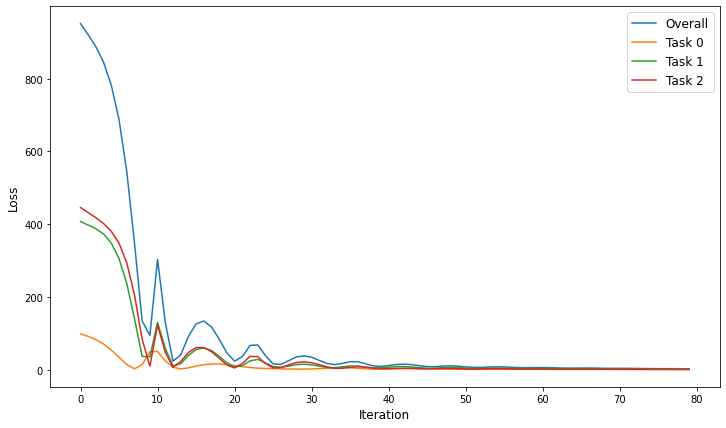

In [8]:
# Visualize the individual and combined losses
fig = plt.figure(figsize=(12, 7))

max_it = 80
plt.plot(losses[-1][:max_it], label='Overall')
plt.plot(losses[0][:max_it], label='Task 0')
plt.plot(losses[1][:max_it], label='Task 1')
plt.plot(losses[2][:max_it], label='Task 2')

plt.legend(fontsize=12)
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("Loss", fontsize=12)